In [1]:
import pandas as pd
import datetime as dt

In [2]:
def fix_date(x:[str]):
    if " " in str(x):
        if len(str(x.split(" ")[1])) == 1:
            return str(x.split(" ")[0]+"0"+str(x.split(" ")[1]))
        else:
            return str(x.replace(" ",""))
    else:
        return x

In [3]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

### Read all .xlsx files available (aug2018 and feb2016 will be missing (only pdf provided))

In [4]:
data = pd.DataFrame()
for y in range(2015,2022):
    for m in range(1,13):
        if y == 2016 and m == 2:
            continue
        filename = f"./xlsx_files/SB_H01-01-00_{y}m{str(m).zfill(2)}_BE.xlsx"
        try:
            this_month_df = pd.read_excel(filename, sheet_name="Tabelle 3", skiprows=lambda x: x not in range(6, 38))
        except ValueError:
            print("Check:", filename)
        else:    
            print(".", end="")
            this_month_df.rename(columns={'Unnamed: 0': 'day', 'Unnamed: 1': 'weekday', 'Unnamed: 2': 'acc_w_inj', 'Unnamed: 3': 'fatal1',
                           'Unnamed: 4': 'serious1', 'Unnamed: 5': 'light1', 'Unnamed: 6': 'fatal', 'Unnamed: 7': 'serious', 
                           'Unnamed: 8': 'light', 'Unnamed: 9': 'serious_only_prop_damage', 'Unnamed: 10': 'serious_combined'}, 
                              inplace=True)
            this_month_df["YYYYMM"] = int(str(y)+str(m).zfill(2))

            data = pd.concat([data, this_month_df], axis=0)

..........................................Check: ./xlsx_files/SB_H01-01-00_2018m08_BE.xlsx
........................................

In [5]:
data.head(10)

,day,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,serious_combined,YYYYMM,Unnamed: 11,Unnamed: 12
0,1.0,Donnerstag,12.0,–,3,9.0,–,3,12.0,7,19.0,201501,NaN,NaN
1,2.0,Freitag,18.0,–,1,17.0,–,1,21.0,3,21.0,201501,NaN,NaN
2,3.0,Samstag,14.0,–,1,13.0,–,1,16.0,2,16.0,201501,NaN,NaN
3,4.0,Sonntag,18.0,–,4,14.0,–,4,17.0,4,22.0,201501,NaN,NaN
4,5.0,Montag,28.0,–,3,25.0,–,3,29.0,1,29.0,201501,NaN,NaN
5,6.0,Dienstag,26.0,–,4,22.0,–,4,23.0,3,29.0,201501,NaN,NaN
6,7.0,Mittwoch,31.0,–,5,26.0,–,8,34.0,5,36.0,201501,NaN,NaN
7,8.0,Donnerstag,47.0,–,3,44.0,–,3,55.0,8,55.0,201501,NaN,NaN
8,9.0,Freitag,38.0,–,7,31.0,–,9,40.0,8,46.0,201501,NaN,NaN
9,10.0,Samstag,17.0,–,2,15.0,–,2,22.0,1,18.0,201501,NaN,NaN


### Basic cleanup

In [6]:
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [7]:
data.weekday.value_counts()

Donnerstag    357
Freitag       357
Samstag       357
Sonntag       357
Dienstag      357
Montag        356
Mittwoch      356
Insgesamt       2
Name: weekday, dtype: int64

In [8]:
data = data[data.weekday != "Insgesamt"]

In [9]:
data.weekday.value_counts()

Donnerstag    357
Freitag       357
Samstag       357
Sonntag       357
Dienstag      357
Montag        356
Mittwoch      356
Name: weekday, dtype: int64

In [10]:
data.weekday.isna().value_counts()

False    2497
True       43
Name: weekday, dtype: int64

In [11]:
data = data[data.weekday.isna() == False]

In [12]:
# replace – with 0
for col in data.columns:
    data[col] = list(map(lambda x: 0 if str(x) == "–" else x, data[col]))

In [13]:
# make all relevant columns int
for col in ['acc_w_inj', 'fatal1', 'serious1', 'light1', 'fatal', 'serious', 'light', 
            'serious_only_prop_damage', 'serious_combined']:
    data[col] = data[col].astype(np.int64)

### Create date column

In [14]:
data["day"] = data.day.astype(str)
data["day1"] = list(map(lambda x: x.split(".")[0].zfill(2), data.day))
data["rest"] = list(map(lambda x: str(x)[:4]+"_"+str(x)[4:]+"_", data.YYYYMM))
data["date"] = data.rest + data.day1

In [15]:
data.drop(["day", "day1", "rest"], axis=1, inplace=True)
data = data[['date', 'weekday', 'acc_w_inj', 'fatal1', 'serious1', 'light1', 'fatal', 'serious', 'light',
             'serious_only_prop_damage', 'serious_combined', 'YYYYMM']]

+ Check for missing dates (should be 2557 days, minus 29 for feb2016 and 31 for oct2018)

In [16]:
len(data) == 2557 - 29 - 31

True

### Add missing months from manually produced csv's from pdf's of these months 

In [17]:
aug18 = pd.read_csv("./manual/201808.csv")
aug18["YYYYMM"] = 201808
feb16 = pd.read_csv("./manual/201602.csv")
feb16["YYYYMM"] = 201602

In [18]:
missing_df = pd.concat([aug18, feb16], axis=0)

+ add date column

In [19]:
missing_df["day"] = missing_df.day.astype(str)
missing_df["day1"] = list(map(lambda x: x.split(".")[0].zfill(2), missing_df.day))
missing_df["rest"] = list(map(lambda x: str(x)[:4]+"_"+str(x)[4:]+"_", missing_df.YYYYMM))
missing_df["date"] = missing_df.rest + missing_df.day1

In [20]:
missing_df.drop(["day", "day1", "rest"], axis=1, inplace=True)
missing_df = missing_df[['date', 'weekday', 'acc_w_inj', 'fatal1', 'serious1', 'light1', 'fatal', 'serious', 'light',
             'serious_only_prop_damage', 'serious_combined', 'YYYYMM']]

+ concat data and missing_df

In [21]:
data = pd.concat([data, missing_df], axis=0)

In [22]:
data = data.sort_values("date")

In [23]:
data.reset_index(drop=True)

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,serious_combined,YYYYMM
0,2015_01_01,Donnerstag,12,0,3,9,0,3,12,7,19,201501
1,2015_01_02,Freitag,18,0,1,17,0,1,21,3,21,201501
2,2015_01_03,Samstag,14,0,1,13,0,1,16,2,16,201501
3,2015_01_04,Sonntag,18,0,4,14,0,4,17,4,22,201501
4,2015_01_05,Montag,28,0,3,25,0,3,29,1,29,201501
...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2021_12_27,Montag,15,0,1,14,0,1,19,3,18,202112
2553,2021_12_28,Dienstag,22,0,3,19,0,3,24,2,24,202112
2554,2021_12_29,Mittwoch,26,0,6,20,0,6,22,2,28,202112
2555,2021_12_30,Donnerstag,39,1,3,35,1,3,40,2,41,202112


In [24]:
data.rename(columns={'serious_combined': 'combined_inj_seriousprop'}, inplace=True)

+ fix broken dates in feb2021

In [25]:
data[data.YYYYMM == 202102].sample(4)

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM
24,2021_02_ 25,Donnerstag,33,0,2,31,0,2,38,2,35,202102
2,2021_02_ 3,Mittwoch,29,0,5,24,0,5,31,2,31,202102
17,2021_02_ 18,Donnerstag,19,0,2,17,0,2,20,1,20,202102
12,2021_02_ 13,Samstag,9,0,1,8,0,1,9,0,9,202102


In [26]:
base = dt.datetime.date(dt.datetime.strptime("2021_12_31", "%Y_%m_%d"))
date_list = [base - dt.timedelta(days=x) for x in range(2557)]
date_list = [dt.datetime.strftime(d, "%Y_%m_%d") for d in date_list]

In [27]:
dates1 = data.date.to_list()
print(len(date_list), len(dates1))

2557 2557


In [28]:
miss = [_ for _ in dates1 if _ not in date_list]
miss[:4]

['2021_02_ 1', '2021_02_ 10', '2021_02_ 11', '2021_02_ 12']

In [29]:
data[data.YYYYMM == 202102].sample(4)

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM
27,2021_02_ 28,Sonntag,10,0,0,10,0,0,13,2,12,202102
11,2021_02_ 12,Freitag,9,0,1,8,0,1,8,3,12,202102
1,2021_02_ 2,Dienstag,32,1,6,25,3,8,31,4,36,202102
5,2021_02_ 6,Samstag,10,0,0,10,0,0,13,4,14,202102


In [30]:
data["date"] = list(map(fix_date, data.date))

In [31]:
data

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM
0,2015_01_01,Donnerstag,12,0,3,9,0,3,12,7,19,201501
1,2015_01_02,Freitag,18,0,1,17,0,1,21,3,21,201501
2,2015_01_03,Samstag,14,0,1,13,0,1,16,2,16,201501
3,2015_01_04,Sonntag,18,0,4,14,0,4,17,4,22,201501
4,2015_01_05,Montag,28,0,3,25,0,3,29,1,29,201501
...,...,...,...,...,...,...,...,...,...,...,...,...
26,2021_12_27,Montag,15,0,1,14,0,1,19,3,18,202112
27,2021_12_28,Dienstag,22,0,3,19,0,3,24,2,24,202112
28,2021_12_29,Mittwoch,26,0,6,20,0,6,22,2,28,202112
29,2021_12_30,Donnerstag,39,1,3,35,1,3,40,2,41,202112


In [32]:
dates1 = data.date.to_list()
miss = [_ for _ in dates1 if _ not in date_list]
miss[:4]

[]

In [33]:
data1 = data.copy()
data1

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM
0,2015_01_01,Donnerstag,12,0,3,9,0,3,12,7,19,201501
1,2015_01_02,Freitag,18,0,1,17,0,1,21,3,21,201501
2,2015_01_03,Samstag,14,0,1,13,0,1,16,2,16,201501
3,2015_01_04,Sonntag,18,0,4,14,0,4,17,4,22,201501
4,2015_01_05,Montag,28,0,3,25,0,3,29,1,29,201501
...,...,...,...,...,...,...,...,...,...,...,...,...
26,2021_12_27,Montag,15,0,1,14,0,1,19,3,18,202112
27,2021_12_28,Dienstag,22,0,3,19,0,3,24,2,24,202112
28,2021_12_29,Mittwoch,26,0,6,20,0,6,22,2,28,202112
29,2021_12_30,Donnerstag,39,1,3,35,1,3,40,2,41,202112


In [34]:
len(data)

2557

In [35]:
for col in data1.columns:
    data1[col] = list(map(lambda x: 0 if str(x) == "–" else x, data[col]))

In [36]:
data.sample(5)

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM
13,2018_09_14,Freitag,50,0,8,42,0,8,47,4,54,201809
21,2018_06_22,Freitag,58,0,7,51,0,7,58,2,60,201806
15,2019_02_16,Samstag,22,0,3,19,0,3,21,5,27,201902
12,2019_11_13,Mittwoch,26,0,4,22,0,4,25,4,30,201911
3,2015_10_04,Sonntag,23,0,4,19,0,4,34,3,26,201510


### Add columns for bank holiday, school vacation and lockdown (as 1 and 0 for aggregate function)

In [37]:
# dates scraped with vacation_scraper.py
with open("./data/school_vacation_days_berlin.txt") as f:
    school_vac_lst = f.read().splitlines()
with open("./data/bank_holidays_berlin.txt") as f:
    bank_holid_lst = f.read().splitlines()
with open("./data/lockdown_dates.txt") as f:
    lockdown_dates = f.read().splitlines()

In [38]:
data["bank_holiday"] = list(map(lambda x: 1 if x in bank_holid_lst else 0, data.date))
data["school_vacation"] = list(map(lambda x: 1 if x in school_vac_lst else 0, data.date))
data["lockdown"] = list(map(lambda x: 1 if x in lockdown_dates else 0, data.date))

In [39]:
data

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM,bank_holiday,school_vacation,lockdown
0,2015_01_01,Donnerstag,12,0,3,9,0,3,12,7,19,201501,1,0,0
1,2015_01_02,Freitag,18,0,1,17,0,1,21,3,21,201501,0,0,0
2,2015_01_03,Samstag,14,0,1,13,0,1,16,2,16,201501,0,0,0
3,2015_01_04,Sonntag,18,0,4,14,0,4,17,4,22,201501,0,0,0
4,2015_01_05,Montag,28,0,3,25,0,3,29,1,29,201501,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,2021_12_27,Montag,15,0,1,14,0,1,19,3,18,202112,0,1,0
27,2021_12_28,Dienstag,22,0,3,19,0,3,24,2,24,202112,0,1,0
28,2021_12_29,Mittwoch,26,0,6,20,0,6,22,2,28,202112,0,1,0
29,2021_12_30,Donnerstag,39,1,3,35,1,3,40,2,41,202112,0,1,0


### Add weather data columns


#### Read Data scraped from three weather stations in Berlin

In [40]:
weather_thf = pd.read_csv("./data/weather_data_tempelhof.csv", sep=";")

In [41]:
weather_thf.head()

,date,min_temp,max_temp,avg_temp,percipation_amnt,sunshine_hrs,max_wind_bft,snow_height
0,01.01.2015,"2,3",6,"3,9",0,"4,8",536,-
1,02.01.2015,3,"8,2","5,4","1,2","0,4",760,-
2,03.01.2015,"3,4","5,9","4,8","0,3",0,865,-
3,04.01.2015,"1,6",5,"3,6","0,8","1,7",862,-
4,05.01.2015,"2,1",4,"3,4","2,5",0,750,-


In [42]:
aver_temps_thf = [float(_.replace(",", ".")) for _ in weather_thf.avg_temp.to_list()]
perci_thf = [float(str(_).replace(",", ".")) for _ in weather_thf.percipation_amnt.to_list()]
sunsh_thf = [float(str(_).replace(",", ".")) for _ in weather_thf.sunshine_hrs.to_list()]
snow_height_thf = weather_thf.snow_height.to_list()   # no snow data provided
set(snow_height_thf)

{'-'}

In [43]:
weather_mrz = pd.read_csv("./data/weather_data_marzahn.csv", sep=";")

In [44]:
aver_temps_mrz = [float(_.replace(",", ".")) for _ in weather_mrz.avg_temp.to_list()]
perci_mrz = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_mrz.percipation_amnt.to_list()]
sunsh_mrz = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_mrz.sunshine_hrs.to_list()]
snow_height_mrz = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_mrz.snow_height.to_list()]


In [45]:
weather_dlm = pd.read_csv("./data/weather_data_dahlem.csv", sep=";")

In [46]:
aver_temps_dlm = [float(_.replace(",", ".")) for _ in weather_dlm.avg_temp.to_list()]
perci_dlm = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_dlm.percipation_amnt.to_list()]
sunsh_dlm = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_dlm.sunshine_hrs.to_list()]
snow_height_dlm = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_dlm.snow_height.to_list()]


#### Built four columns with averaged data of this weather station df's

In [47]:
aver_temp_three = np.array([aver_temps_thf, aver_temps_mrz, aver_temps_dlm])
perci_three = np.array([perci_thf, perci_mrz, perci_dlm])
sunsh_three = np.array([sunsh_thf, sunsh_mrz, sunsh_dlm])
snow_height_three = np.array([snow_height_mrz, snow_height_dlm])    # only two, no snow data for thf

aver_temp_bln = [round(_, 1) for _ in list(np.average(aver_temp_three, axis=0))]
perci_bln = [round(_, 1) for _ in list(np.average(perci_three, axis=0))]
sunsh_bln = [round(_, 1) for _ in list(np.average(sunsh_three, axis=0))]
snow_height_bln = [round(_, 1) for _ in list(np.average(snow_height_three, axis=0))]

In [48]:
data["aver_temp"] = aver_temp_bln
data["percipation_mm"] = perci_bln
data["sunshine_hours"] = sunsh_bln
data["snow_height_mm"] = snow_height_bln

In [49]:
# data[data.percipation_mm == max(data.percipation_mm)]

In [50]:
data.sample(5)

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM,bank_holiday,school_vacation,lockdown,aver_temp,percipation_mm,sunshine_hours,snow_height_mm
17,2016_08_18,Donnerstag,41,1,4,36,1,4,39,2,43,201608,0,1,0,15.9,0.0,0.6,0.0
12,2015_01_13,Dienstag,33,0,3,30,0,3,34,6,39,201501,0,0,0,9.9,3.1,2.3,0.0
17,2017_06_18,Sonntag,38,0,11,27,0,12,35,0,38,201706,0,0,0,19.9,0.0,10.4,0.0
26,2019_07_27,Samstag,41,0,11,30,0,16,36,2,43,201907,0,1,0,23.5,0.0,8.1,0.0
11,2020_02_12,Mittwoch,24,0,2,22,0,2,26,2,26,202002,0,0,0,4.6,0.0,0.4,0.0


In [139]:
# save as csv
data.to_csv("./data/accident_records_by_day.csv", index=False)

### Create weather and "off"-days csv for combining with other dataset

+ list of relevant months (other dataset contains data for years 2018 - 2020)

In [65]:
relevant = [_ for _ in sorted(list(data.YYYYMM.value_counts().index)) if 201712 < _ < 2021_01]

+ extract weather data for these 36 months

In [76]:
# groupby agg sum() for vac, bank_holi, lockdown, perci, sunsh_hrs and snow
data_extr = data[['bank_holiday', 'school_vacation', 'lockdown', 'percipation_mm', 'sunshine_hours', 'snow_height_mm', "YYYYMM"]].groupby("YYYYMM").sum()

In [78]:
# groupby agg mean() for aver_temp
data_extr_t = data[['aver_temp', "YYYYMM"]].groupby("YYYYMM").mean()

In [84]:
data_extr["aver_temp"] = round(data_extr_t["aver_temp"],1)

In [117]:
data_extr["YYYYMM"] = data_extr.index

TypeError: 'Int64Index' object is not callable

In [115]:
data_extract = data_extr[data_extr.YYYYMM.isin(relevant)]

In [122]:
data_extract = data_extract.reset_index(drop=True)
data_extract.head(5)

,bank_holiday,school_vacation,lockdown,percipation_mm,sunshine_hours,snow_height_mm,aver_temp,YYYYMM
0,1,0,0,67.2,19.5,3.0,3.6,201801
1,0,6,0,2.7,98.5,0.0,-0.9,201802
2,1,6,0,44.1,84.4,1.5,1.8,201803
3,1,7,0,38.0,170.9,0.0,13.7,201804
4,3,2,0,15.2,232.2,0.0,17.9,201805


In [131]:
data_first = pd.read_csv("./data/monthly_incl_alc.csv")


In [133]:
data_first.rename(columns={"month_num":"YYYYMM"}, inplace=True)
data_first

,month,bicycle,car,pedestrian,motorbike,truck,other,slightly_injured,seriously_injured,killed,total_acc_w_injury,alcohol_related,daylight,dark,dusk,dry,wet,icy,YYYYMM
0,2018_01,245,758,247,50,28,129,720,161,3,884,89,388,401,95,358,509,17,201801
1,2018_02,201,640,153,39,30,101,608,119,3,730,100,447,235,48,602,107,21,201802
2,2018_03,222,700,154,65,27,110,691,109,2,802,108,566,190,46,516,265,21,201803
3,2018_04,453,1008,148,214,38,168,1011,202,4,1217,101,1051,123,43,1067,150,0,201804
4,2018_05,679,1174,190,257,62,184,1199,261,2,1462,132,1315,96,51,1424,38,0,201805
5,2018_06,647,1153,177,289,46,183,1251,212,3,1466,106,1342,88,36,1370,96,0,201806
6,2018_07,547,987,125,241,41,162,1054,179,3,1236,124,1097,104,35,1163,73,0,201807
7,2018_08,553,1017,135,274,32,179,1085,223,4,1312,106,1144,117,51,1248,64,0,201808
8,2018_09,572,1027,150,292,42,148,1100,223,5,1328,117,1073,179,76,1194,134,0,201809
9,2018_10,448,1037,176,225,42,177,1059,186,3,1248,96,867,254,127,999,249,0,201810


In [134]:
data_comb = pd.merge(data_first, data_extract, on='YYYYMM')
data_comb

,month,bicycle,car,pedestrian,motorbike,truck,other,slightly_injured,seriously_injured,killed,...,wet,icy,YYYYMM,bank_holiday,school_vacation,lockdown,percipation_mm,sunshine_hours,snow_height_mm,aver_temp
0,2018_01,245,758,247,50,28,129,720,161,3,...,509,17,201801,1,0,0,67.2,19.5,3.0,3.6
1,2018_02,201,640,153,39,30,101,608,119,3,...,107,21,201802,0,6,0,2.7,98.5,0.0,-0.9
2,2018_03,222,700,154,65,27,110,691,109,2,...,265,21,201803,1,6,0,44.1,84.4,1.5,1.8
3,2018_04,453,1008,148,214,38,168,1011,202,4,...,150,0,201804,1,7,0,38.0,170.9,0.0,13.7
4,2018_05,679,1174,190,257,62,184,1199,261,2,...,38,0,201805,3,2,0,15.2,232.2,0.0,17.9
5,2018_06,647,1153,177,289,46,183,1251,212,3,...,96,0,201806,0,0,0,26.5,156.3,0.0,19.3
6,2018_07,547,987,125,241,41,162,1054,179,3,...,73,0,201807,0,27,0,70.5,222.3,0.0,21.6
7,2018_08,553,1017,135,274,32,179,1085,223,4,...,64,0,201808,0,17,0,6.8,185.3,0.0,21.6
8,2018_09,572,1027,150,292,42,148,1100,223,5,...,134,0,201809,0,0,0,21.4,141.7,0.0,16.7
9,2018_10,448,1037,176,225,42,177,1059,186,3,...,249,0,201810,1,10,0,16.5,114.3,0.0,11.3


In [140]:
# save to csv
data_comb.to_csv("./data/combined_numbers_weather_days_2018-2020.csv", index=False)

### Read in all accident csv (incl. only-property damage)

In [55]:
all_acc_df = pd.read_csv("./data/all_acc_summary_monthly.csv")

+ cleaning

In [56]:
all_acc_df.head(5)

,YYYYMM,total,acc_w_injuries,only_prop_total,only_prop_enger_sinn,only_prop_dui,rest_acc_prop,injur_acc,fatal,injured,seriously_of_these
0,201501,10 169,873,9 296,106,51,9 139,1 063,3,1 060,120
1,201502,9 723,805,8 918,99,40,8 779,965,1,964,102
2,201503,11 747,1 046,10 701,115,48,10 538,1 226,1,1 225,142
3,201504,11 299,1 188,10 111,83,45,9 983,1 457,2,1 455,164
4,201505,11 255,1 496,9 759,95,68,9 596,1 771,5,1 766,200


In [57]:
for col in all_acc_df.columns:
    all_acc_df[col] = list(map(lambda x: int(str(x).replace("–", "0").replace(" ", "")), all_acc_df[col]))

In [58]:
all_acc_df.head(5)

,YYYYMM,total,acc_w_injuries,only_prop_total,only_prop_enger_sinn,only_prop_dui,rest_acc_prop,injur_acc,fatal,injured,seriously_of_these
0,201501,10169,873,9296,106,51,9139,1063,3,1060,120
1,201502,9723,805,8918,99,40,8779,965,1,964,102
2,201503,11747,1046,10701,115,48,10538,1226,1,1225,142
3,201504,11299,1188,10111,83,45,9983,1457,2,1455,164
4,201505,11255,1496,9759,95,68,9596,1771,5,1766,200


C:\Users\roman\AppData\Local\Temp/ipykernel_3224/3820423509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_per_month["YYYY_MM"] = list(map(lambda x: str(x)[:4]+"_"+str(x)[4:], total_per_month.YYYYMM))


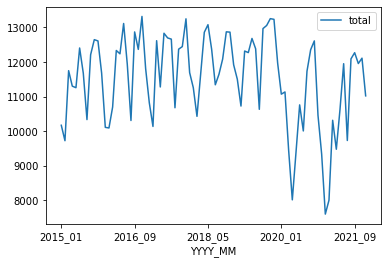

In [167]:
# all years
total_per_month = all_acc_df[["YYYYMM", "total"]]
total_per_month["YYYY_MM"] = list(map(lambda x: str(x)[:4]+"_"+str(x)[4:], total_per_month.YYYYMM))
total_per_month = total_per_month[["YYYY_MM", "total"]]
total_per_month.plot(x="YYYY_MM")
total_per_month.to_csv("./data/total_acc_by_month_csv_2015-21.csv", index=False)

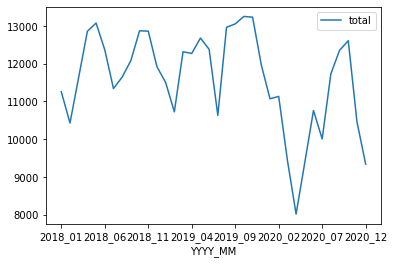

In [168]:
# 2018-2020
total_per_month = all_acc_df[["YYYYMM", "total"]][(all_acc_df.YYYYMM > 201712) & (all_acc_df.YYYYMM < 202101)]
total_per_month["YYYY_MM"] = list(map(lambda x: str(x)[:4]+"_"+str(x)[4:], total_per_month.YYYYMM))
total_per_month = total_per_month[["YYYY_MM", "total"]]
total_per_month.plot(x="YYYY_MM")
total_per_month.to_csv("./data/total_acc_by_month_csv_2018-20.csv", index=False)

### Bike accident with injuries over years incl. relative numbers on all accidents with injuries

In [348]:
bicycle_acc = pd.DataFrame()
acc_total = []
for y in range(2015,2022):
    for m in range(1,13):
        if y == 2016 and m == 2:
            continue
        filename = f"./xlsx_files/SB_H01-01-00_{y}m{str(m).zfill(2)}_BE.xlsx"
        try:
            this_month_df = pd.read_excel(filename, sheet_name="Tabelle 7", skiprows=lambda x: x not in range(10, 37))
        except ValueError:
            print("Check:", filename)
        else:    
            print(".", end="")
            acc_total.append(this_month_df.columns[1])
            this_month_df.rename(columns={this_month_df.columns[0]: "cat", this_month_df.columns[1]: "total_bic", 
                                          this_month_df.columns[2]: "fatal", this_month_df.columns[3]: "serious", 
                                          this_month_df.columns[4]: "light"}, inplace=True)
            this_month_df = this_month_df[["cat", "total_bic","fatal","serious","light"]]
            # this_month_df = this_month_df.loc[this_month_df["cat"] == "Fahrrädern"]
            this_month_df = this_month_df.loc[this_month_df.cat.str.contains("Fahrr")]
            this_month_df["YYYYMM"] = int(str(y)+str(m).zfill(2))
            bicycle_acc = pd.concat([bicycle_acc, this_month_df], axis=0)

bicycle_acc["total_acc"] = acc_total
bicycle_acc.head()

..........................................Check: ./xlsx_files/SB_H01-01-00_2018m08_BE.xlsx
........................................

,cat,total_bic,fatal,serious,light,YYYYMM,total_acc
20,Fahrrädern,204,–,19,190,201501,868
20,Fahrrädern,236,–,25,225,201502,802
20,Fahrräder,344,–,42,316,201503,1041
20,Fahrräder,432,1,53,412,201504,1186
20,Fahrräder,660,3,77,618,201505,1493
...,...,...,...,...,...,...,...
21,Fahrrädern,626,–,96,566,202108,1406
21,Fahrrädern,576.0,2,68,546,202109,1452
21,Fahrrädern,439,1,57,404,202110,1253
21,Fahrrädern,363,–,37,351,202111,1119


+ missing data (s.a.)

In [349]:
bicycle_acc.loc[len(bicycle_acc)] = ["Fahrrädern", 326, 1, 37, 304, 201602, 1497]
bicycle_acc.loc[len(bicycle_acc)] = ["Fahrrädern", 619, 1, 88, 595, 201808, 1441]

In [351]:
bicycle_acc = bicycle_acc.sort_values("YYYYMM")
bicycle_acc.reset_index(drop=True)

for col in ["fatal", "serious", "light"]:
    bicycle_acc[col] = list(map(lambda x: 0 if x=="–" else x, bicycle_acc[col]))
    bicycle_acc[col] = bicycle_acc[col].astype("int64")
bicycle_acc.total_bic = bicycle_acc.total_bic.astype("int64")

+ create bike percentage column

In [354]:
bike_t = bicycle_acc.total_bic.to_list()
acc_t = bicycle_acc.total_acc.to_list()
bike_perc = []
for i in range(len(bike_t)):
    bike_perc.append(round(bike_t[i]*100/acc_t[i], 2))
bicycle_acc["bike_percentage"] = bike_perc
bicycle_acc

,cat,total_bic,fatal,serious,light,YYYYMM,total_acc,bike_percentage
20,Fahrrädern,204,0,19,190,201501,868,23.50
20,Fahrrädern,236,0,25,225,201502,802,29.43
20,Fahrräder,344,0,42,316,201503,1041,33.05
20,Fahrräder,432,1,53,412,201504,1186,36.42
20,Fahrräder,660,3,77,618,201505,1493,44.21
...,...,...,...,...,...,...,...,...
21,Fahrrädern,626,0,96,566,202108,1406,44.52
21,Fahrrädern,576,2,68,546,202109,1452,39.67
21,Fahrrädern,439,1,57,404,202110,1253,35.04
21,Fahrrädern,363,0,37,351,202111,1119,32.44


In [355]:
# save to csv
# bicycle_acc[['YYYYMM', 'total_bic', 'fatal', 'serious', 'light', "total_acc", "bike_percentage"]].to_csv("./data/bicycle_acc_inj_per_month.csv", index=False)

<AxesSubplot:xlabel='YYYYMM'>

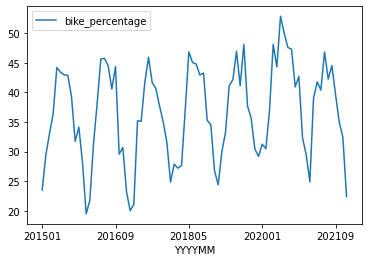

In [357]:
# bicycle_acc = bicycle_acc[['YYYYMM', 'total_', 'fatal', 'serious', 'light']]
bicycle_acc.YYYYMM = bicycle_acc.YYYYMM.astype("string")
bicycle_acc.plot(x="YYYYMM", y="bike_percentage")

In [363]:
bicycle_acc.sort_values("bike_percentage", ascending = False).head(10)

,cat,total_bic,fatal,serious,light,YYYYMM,total_acc,bike_percentage
20,Fahrrädern,738,4,93,710,202006,1396,52.87
20,Fahrrädern,630,2,75,602,202007,1260,50.00
20,Fahrrädern,744,0,89,725,201908,1546,48.12
20,Fahrrädern,395,0,56,367,202004,821,48.11
20,Fahrrädern,741,2,105,693,202008,1557,47.59
20,Fahrrädern,701,0,100,637,202009,1482,47.30
20,Fahrrädern,752,1,109,690,201906,1602,46.94
20,Fahrrädern,753,0,135,677,201805,1607,46.86
21,Fahrrädern,684,1,97,642,202106,1461,46.82
20,Fahrrädern,699,2,99,656,201706,1522,45.93


In [393]:
# code snippets created to get to results

In [ ]:
# tester = pd.read_excel("./xlsx_files/SB_H01-01-00_2021m11_BE.xlsx",
#                                     sheet_name="Tabelle 3",
#                                     skiprows=lambda x: x not in range(6, 39))

# tester.rename(columns={'Unnamed: 0': 'day', 'Unnamed: 1': 'weekay', 'Unnamed: 2': 'acc_w_inj', 'Unnamed: 3': 'fatal1',
#                        'Unnamed: 4': 'serious1', 'Unnamed: 5': 'light1', 'Unnamed: 6': 'fatal', 'Unnamed: 7': 'serious', 
#                        'Unnamed: 8': 'light', 'Unnamed: 9': 'serious_only_prop_damage', 'Unnamed: 10': 'serious_combined'}, 
#                           inplace=True)

# # tester

# tester2 = pd.read_excel("./xlsx_files/SB_H01-01-00_2021m02_BE.xlsx",
#                                     sheet_name="Tabelle 3",
#                                     skiprows=lambda x: x not in range(6, 39))

# tester2.rename(columns={'Unnamed: 0': 'day', 'Unnamed: 1': 'weekay', 'Unnamed: 2': 'acc_w_inj', 'Unnamed: 3': 'fatal1',
#                        'Unnamed: 4': 'serious1', 'Unnamed: 5': 'light1', 'Unnamed: 6': 'fatal', 'Unnamed: 7': 'serious', 
#                        'Unnamed: 8': 'light', 'Unnamed: 9': 'serious_only_prop_damage', 'Unnamed: 10': 'serious_combined'}, 
#                           inplace=True)

# #tester2

In [ ]:
# data1 = data.copy()


# data1["day"] = data1.day.astype(str)
# data1["day1"] = list(map(lambda x: x.split(".")[0].zfill(2), data1.day))
# data1["rest"] = list(map(lambda x: str(x)[:4]+"_"+str(x)[4:]+"_", data1.YYYYMM))
# data1["date"] = data1.rest + data1.day1

# data1.drop(["day", "day1", "rest"], axis=1, inplace=True)


In [317]:
# tester = pd.read_excel("./xlsx_files/SB_H01-01-00_2021m02_BE.xlsx",
#                                     sheet_name="Tabelle 7",
#                                     skiprows=lambda x: x not in range(10, 37))


# this_total = tester.columns[1]


# tester.rename(columns={tester.columns[0]: "cat", tester.columns[1]: "total", tester.columns[2]: "fatal", tester.columns[3]: "serious", 
#                        tester.columns[4]: "light"}, inplace=True)
# tester = tester[["cat","total","fatal","serious","light"]]

# tester
# tester.loc[tester["cat"] == "Unfälle"]


486

In [326]:
bicycle_acc = pd.DataFrame()
total_acc = []
for y in range(2019,2020):
    for m in range(1,6):
        if y == 2016 and m == 2:
            continue
        filename = f"./xlsx_files/SB_H01-01-00_{y}m{str(m).zfill(2)}_BE.xlsx"
        try:
            this_month_df = pd.read_excel(filename, sheet_name="Tabelle 7", skiprows=lambda x: x not in range(10, 37))
        except ValueError:
            print("Check:", filename)
        else:    
            print(".", end="")
            acc_total.append(this_month_df.columns[1])
            this_month_df.rename(columns={this_month_df.columns[0]: "cat", this_month_df.columns[1]: "total_bic", 
                                          this_month_df.columns[2]: "fatal", this_month_df.columns[3]: "serious", 
                                          this_month_df.columns[4]: "light"}, inplace=True)
            this_month_df = this_month_df[["cat", "total_bic","fatal","serious","light"]]
            this_month_df = this_month_df.loc[this_month_df["cat"] == "Fahrrädern"]
            this_month_df["YYYYMM"] = int(str(y)+str(m).zfill(2))

            bicycle_acc = pd.concat([bicycle_acc, this_month_df], axis=0)
bicycle_acc["total_acc"] = acc_total

.....

In [336]:
bicycle_acc["total_acc"] = acc_total
bike_t = bicycle_acc.total_bic.to_list() 
type(acc_total)

list

In [338]:
for i in range(len(bike_t)):
    print(round(bike_t[i]*100/acc_total[i], 2))

24.4
29.99
33.27
41.13
42.14
